#### A5 – FEATURE EXTRACTION PART 1 OF 3: IMAGE SEGMENTATION

Andeo, Lovely\
2020-05405\
FX-2

**Short Exercise**

First is to input all the necesssary libraries and packages needed.

In [141]:
from PIL import Image
import matplotlib.pyplot as plt
import math
from matplotlib.image import imread
from skimage.io import imread, imshow
import numpy as np
import cv2

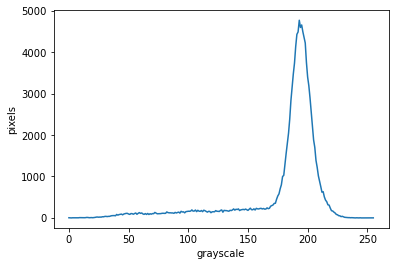

In [2]:
# Loading the grayscale image
I = Image.open('cropped_grayscale_check.jpg').convert('L')

# Calculating the histogram
count, cells = I.histogram(), list(range(256)) # returns list of pixel counts for each intensity level

# Displaying the histogram
plt.plot(cells, count)
plt.xlabel('grayscale')
plt.ylabel('pixels')
plt.show()


Segmenting the regions of interest by setting a threshold

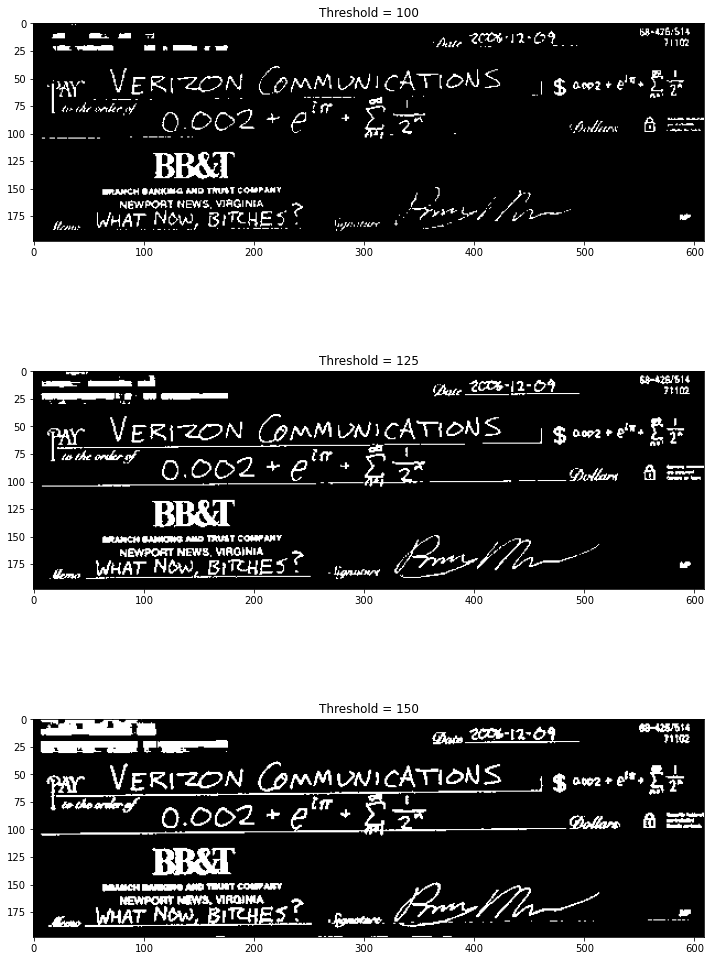

In [3]:
# Defining a list of threshold values to test
thresholds = [100, 125, 150]

# Creating a figure with subplots for each thresholded image
fig, axes = plt.subplots(len(thresholds), 1, figsize=(10, 15))

# Looping over the threshold values and display the thresholded images
for i, t in enumerate(thresholds):
    # Thresholding the image
    BW = np.array(I) < t
    
    # Displaying the thresholded image
    axes[i].imshow(BW, cmap='gray')
    axes[i].set_title('Threshold = {}'.format(t))

plt.tight_layout()
plt.show()


**Parametric vs Non-Parametric Probability Distribution Estimation**
1. Capture or download a digital image of a 3D object with parts that have single color (e.g. colored mugs, skin, NIPS or Skittles candy, colored paper, brightly colored bottles, etc.).
2. Crop a monochromatic region of interest in the scene.
3. Transform color RGB into normalized chromaticity coordinates rgI.
4. Parametric segmentation – derive the Gaussian PDF in the r and g values separately of the
ROI and segment the whole image.
5. Non-parametric segmentation – Obtain the 2D histogram of the ROI. To test if your histogram is correct, compare the location of the peaks with the rg chromaticity diagram in Figure 6. Justify your results. Use the histogram itself to segment the image using histogram backprojection.
6. In your results and discussion, compare the outcomes of the two techniques.

Observe the distribution of the Red and Green color space

In [281]:
def normalize_img(image_name,x1,x2,y1,y2,bin):
    image = imread(image_name)
    roi = image[x1:x2,y1:y2,:]
    # mask = np.isnan(image) | np.isinf(image)
    # image[mask] = 1

    # Load the image
    img = Image.fromarray(image)

    # Getting the normalize RG chromaticity of the image
    img_R = image[:,:,0]*1.0/image.sum(axis=2)
    img_G = image[:,:,1]*1.0/image.sum(axis=2)

    # Scatter plot of the image pixels
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].scatter(img_R.flatten(),img_G.flatten())
    axs[0].set_xlim(0,1)
    axs[0].set_ylim(0,1)
    axs[0].set_title('RG color space distribution')
    # 2D histogram of the image pixels
    axs[1].hist2d(img_R.flatten(), img_G.flatten(), bins=bin,cmap='binary')
    axs[1].set_xlim(0,1)
    axs[1].set_ylim(0,1)
    axs[1].set_title('2D Histogram of color values')
    plt.show()

    # Determining the color location on the histogram, we need a reference patch

    # Display the reference patch
    plt.figure(figsize=(5,5))
    plt.imshow(roi)

    # Getting the normalize RG chromaticity of the patch
    patch_R = roi[:,:,0]*1.0/roi.sum(axis=2)
    patch_G = roi[:,:,1]*1.0/roi.sum(axis=2)
    # Scatter plot of the patch pixels
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].scatter(patch_R.flatten(),patch_G.flatten())
    axs[0].set_xlim(0,1)
    axs[0].set_ylim(0,1)
    axs[0].set_title('Patch pixels distribution')
    # 2D histogram of the patch pixels
    axs[1].hist2d(patch_R.flatten(), patch_G.flatten(), bins=100,cmap='binary')
    axs[1].set_xlim(0,1)
    axs[1].set_ylim(0,1)
    axs[1].set_title('2D histogram of the patch pixels')
    plt.show()

In [143]:
def parametric_seg(image_name,x1,x2,y1,y2):
    image = imread(image_name)
    roi = image[x1:x2,y1:y2,:]

    # Calculating the parameters of the gaussian distribution
    std_patch_R = np.std((roi[:,:,0]*1.0/roi.sum(axis=2)).flatten())
    mean_patch_R = np.mean((roi[:,:,0]*1.0/roi.sum(axis=2)).flatten())
    std_patch_G = np.std((roi[:,:,1]*1.0/roi.sum(axis=2)).flatten())
    mean_patch_G = np.mean((roi[:,:,1]*1.0/roi.sum(axis=2)).flatten())

    # Defining the gaussian function
    def gaussian(p,mean,std):
        return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

    # Checking the distibution of the patch
    x = np.linspace(0,1)
    y = gaussian(x,mean_patch_R,std_patch_R)
    plt.plot(x,y)   

    # Testing the data on the RG Chromaticity space

    # Creating the R and G space arrays
    r_test = np.tile(np.linspace(0,1,64),(64,1))
    g_test = r_test.transpose()

    # Displaying the R and G space arrays
    fig, axs = plt.subplots(1, 2, figsize=(20, 12))
    axs[0].imshow(r_test)
    axs[0].set_title('R Space')
    axs[1].imshow(g_test)
    axs[1].set_title('G Space')

    # Testing sample R and G space into the gaussian distribution with the patch
    test_R = gaussian(r_test,mean_patch_R,std_patch_R)
    test_G = gaussian(g_test,mean_patch_G,std_patch_G)
    prob_test = test_R * test_G

    # Displaying the R and G space with patch and the R*G product
    fig, axs = plt.subplots(1, 3, figsize=(20, 12))
    axs[0].imshow(test_R)
    axs[0].set_title('Test R Space and patch')
    axs[1].imshow(test_G)
    axs[1].set_title('Test G Space and patch')
    axs[2].imshow(prob_test)
    axs[2].set_title('R * G')

    # Calculating the probabilities for the image pixels
    prob_R = gaussian(image[:,:,0]*1.0/image.sum(axis=2),mean_patch_R,std_patch_R)
    prob_G = gaussian(image[:,:,1]*1.0/image.sum(axis=2),mean_patch_G,std_patch_G)
    prob=prob_R * prob_G

    # Ploting the results
    fig, axs = plt.subplots(1, 3, figsize=(20, 12))

    axs[0].imshow(prob_R)
    axs[0].set_title('Image, R chromaticity space')

    axs[1].imshow(prob_G)
    axs[1].set_title('Image, G chromaticity space')

    axs[2].imshow(prob)
    axs[2].set_title('Image, R * G')

    # Isolating the pixels that matches the patch

    mask = prob > 0.8 # threshold
    red = image[:,:,0]*mask
    green = image[:,:,1]*mask
    blue = image[:,:,2]*mask
    image_masked = np.dstack((red,green,blue))

    fig, axs = plt.subplots(1, 3, figsize=(20, 12))

    axs[0].imshow(image)
    axs[0].set_title('Original image')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Binary image')
    
    axs[2].imshow(image_masked)
    axs[2].set_title('Final segmented image')


In [144]:
def nonparametric_seg(image_name,x1,x2,y1,y2, bin):
    # Reading the image
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Defining the green patch
    roi = np.zeros_like(image)
    roi[x1:x2, y1:y2, :] = [0, 255, 0]

    # Converting the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extracting the hue channel
    hue = hsv[:, :, 0]

    # Calculating the histogram of the hue channel
    hist = cv2.calcHist([hue], [0], roi[:, :, 1], [bin], [0, bin])
    cv2.normalize(hist, hist, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Performing back projection using the histogram and the hue channel
    backproj = cv2.calcBackProject([hue], [0], hist, [0, 180], scale=1)

    # Applying a binary threshold to the back projection
    ret, thresh = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY)

    # Applying a morphological opening to remove small objects
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Isolating the pixels that matches the patch
    mask = backproj > 1
    red = image[:,:,0]*mask
    green = image[:,:,1]*mask
    blue = image[:,:,2]*mask
    image_masked = np.dstack((blue,green,red))
    image_masked = cv2.cvtColor(image_masked, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 3, figsize=(20, 12))

    axs[0].imshow(image)
    axs[0].set_title('Original image')

    axs[1].imshow(opening, cmap='gray')
    axs[1].set_title('Binary image')
    
    axs[2].imshow(image_masked)
    axs[2].set_title('Final segmented image')


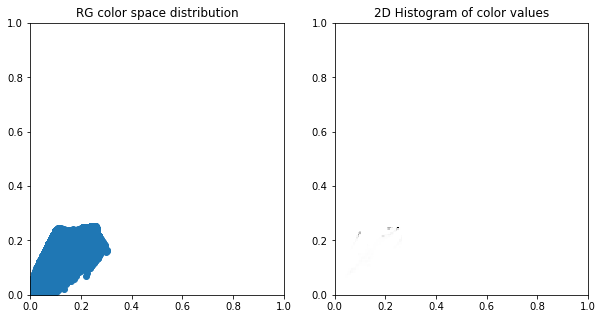

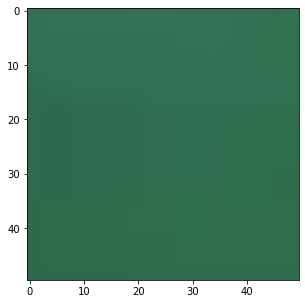

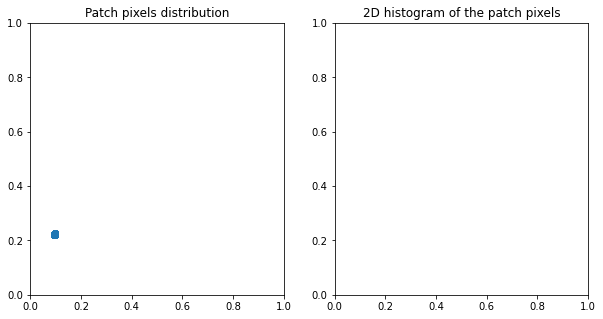

In [182]:
normalize_img('Emma.png',500,550,600,650)

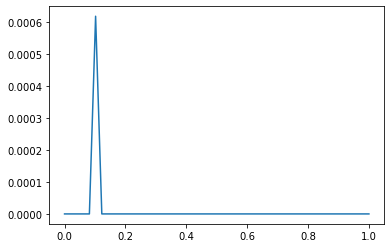

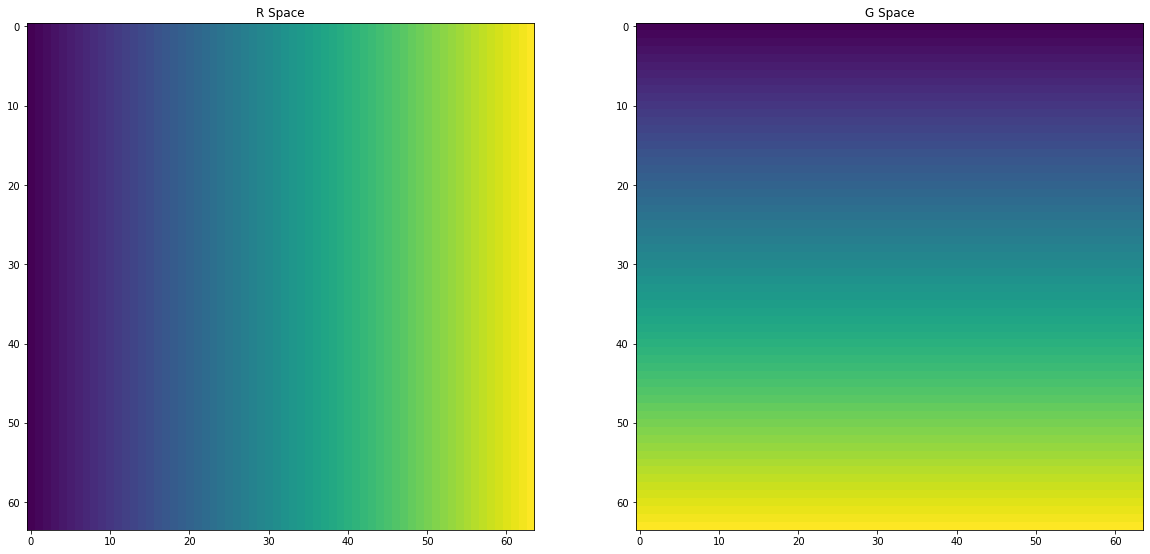

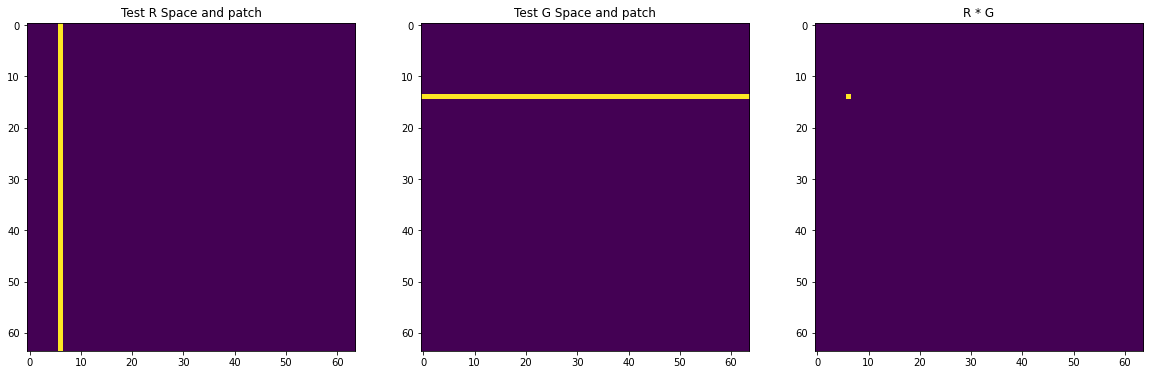

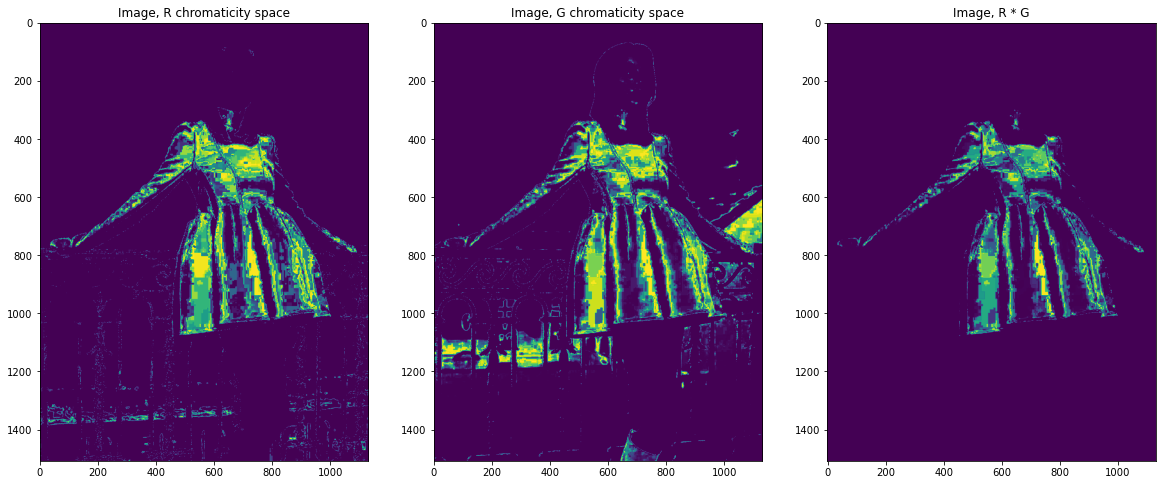

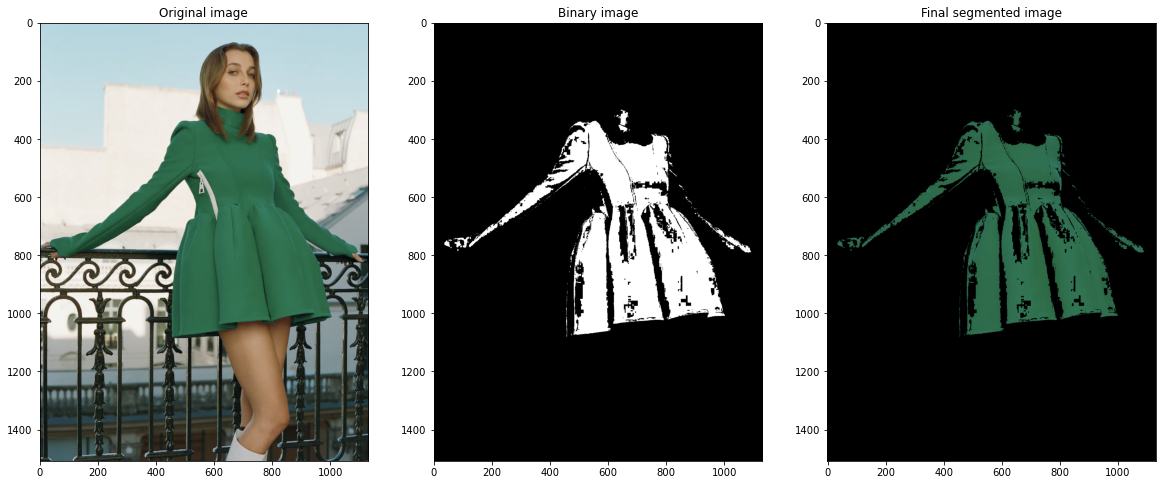

In [130]:
parametric_seg('Emma.png',500,550,600,650)

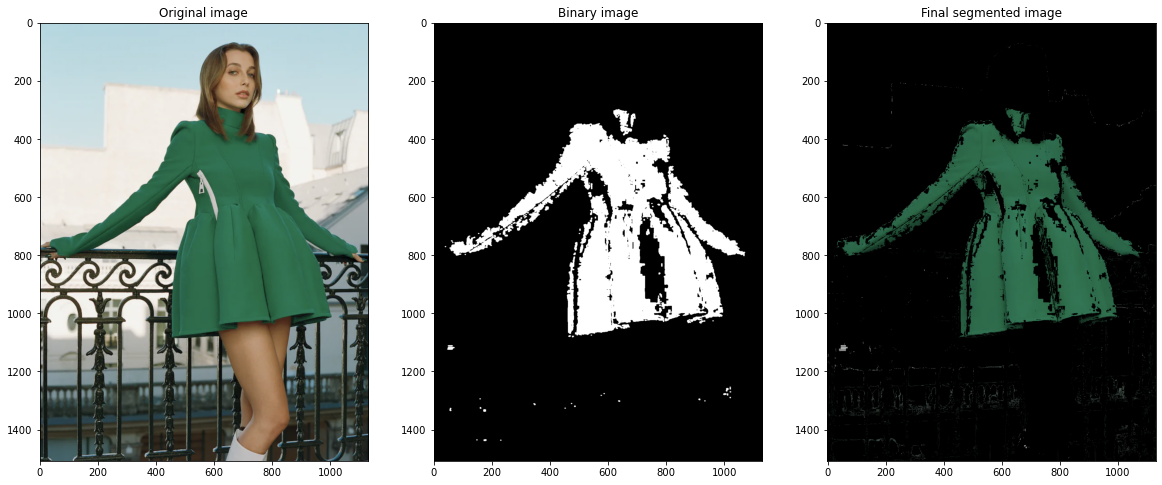

In [138]:
nonparametric_seg('Emma.png',500,550,600,650, 180)

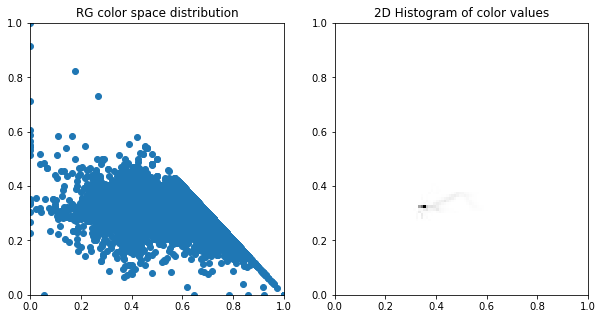

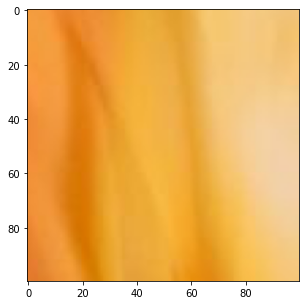

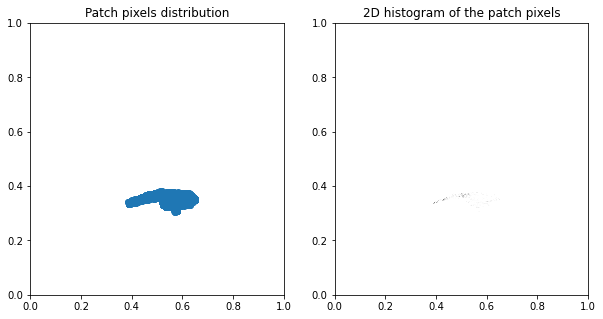

In [249]:
normalize_img('Yellow.jpg',500,600,300,400, 100)

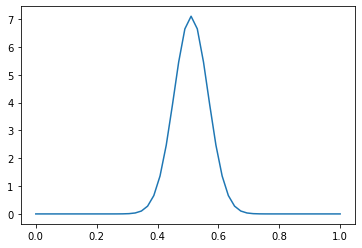

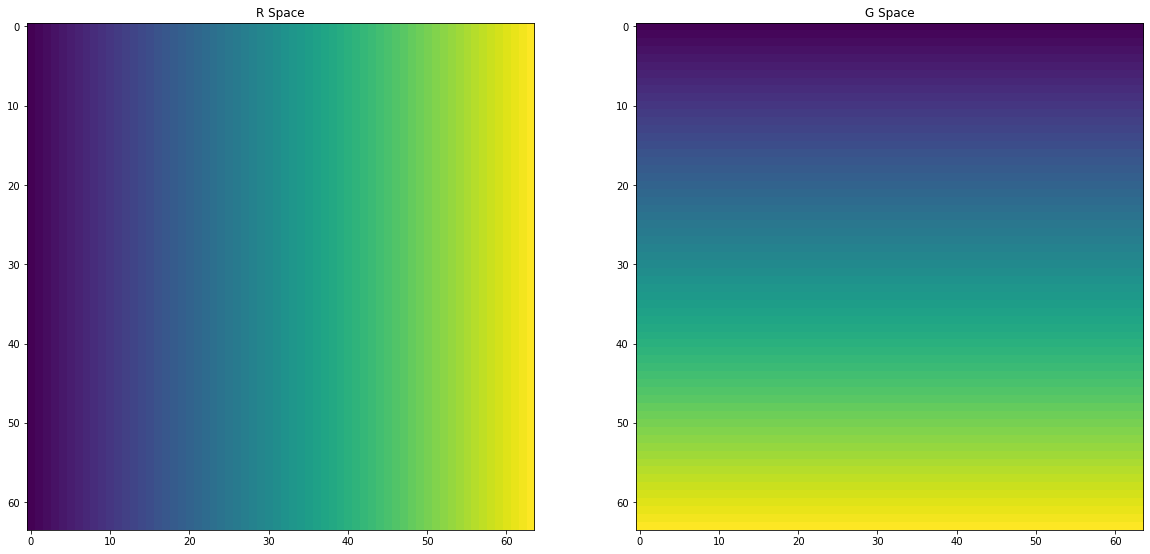

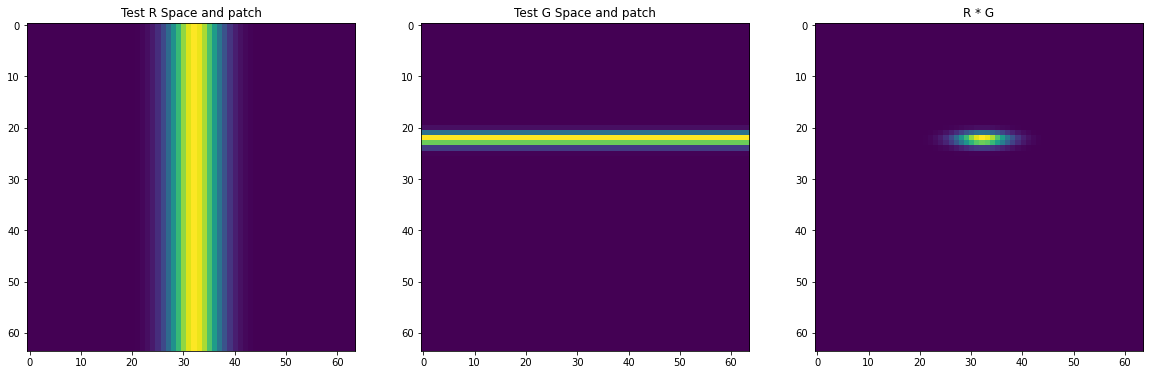

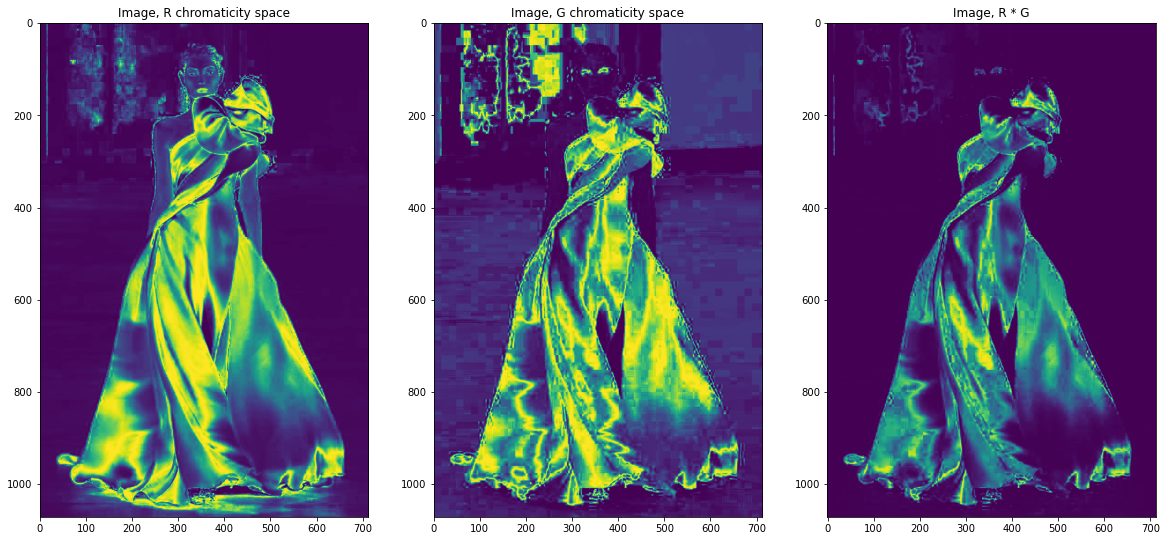

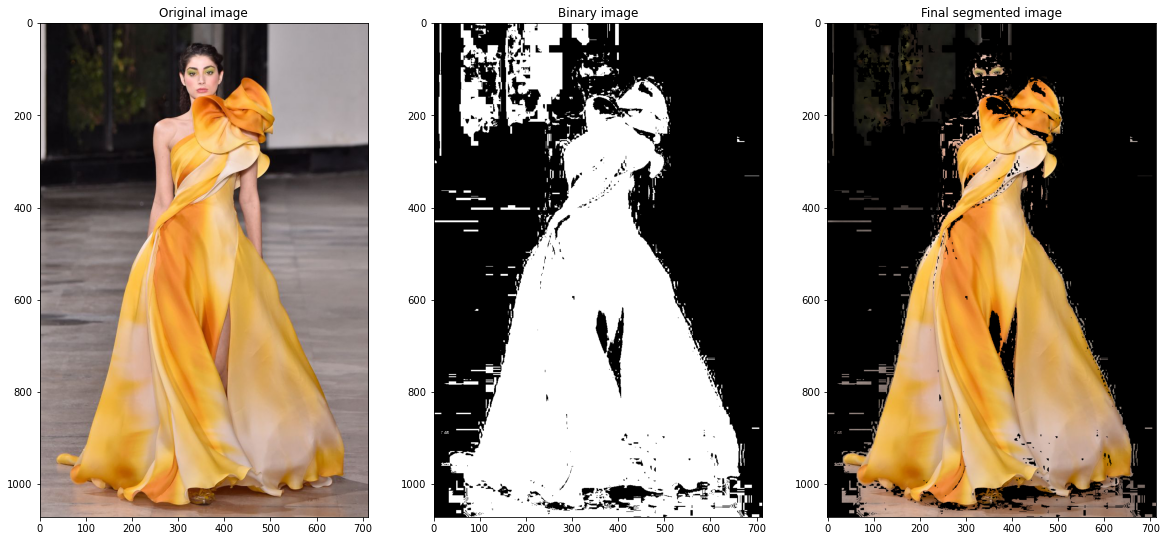

In [216]:
parametric_seg('Yellow.jpg',500,600,300,400)

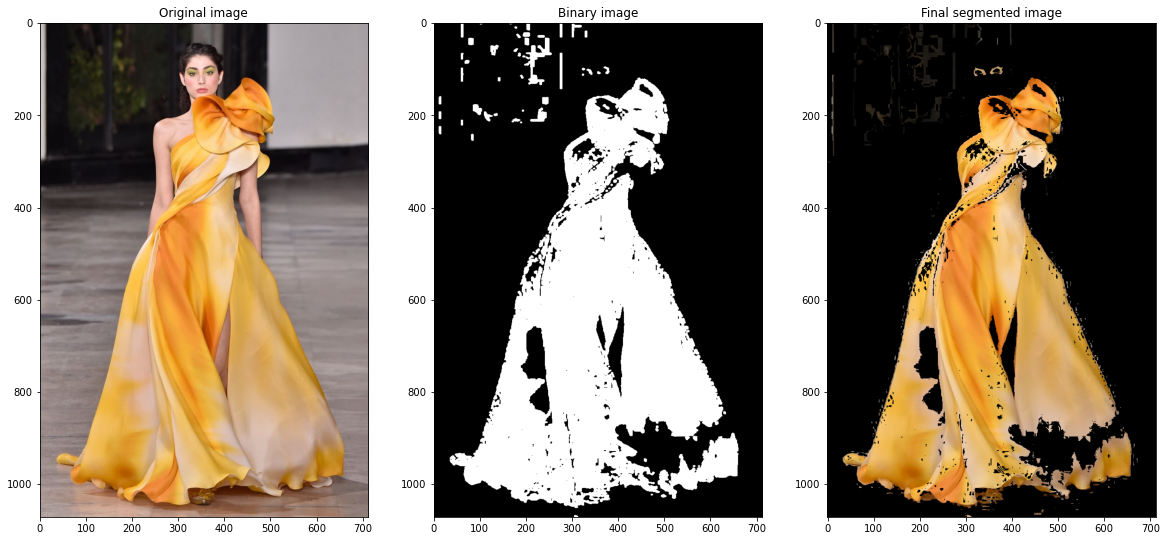

In [221]:
nonparametric_seg('Yellow.jpg',500,600,300,400, 180)

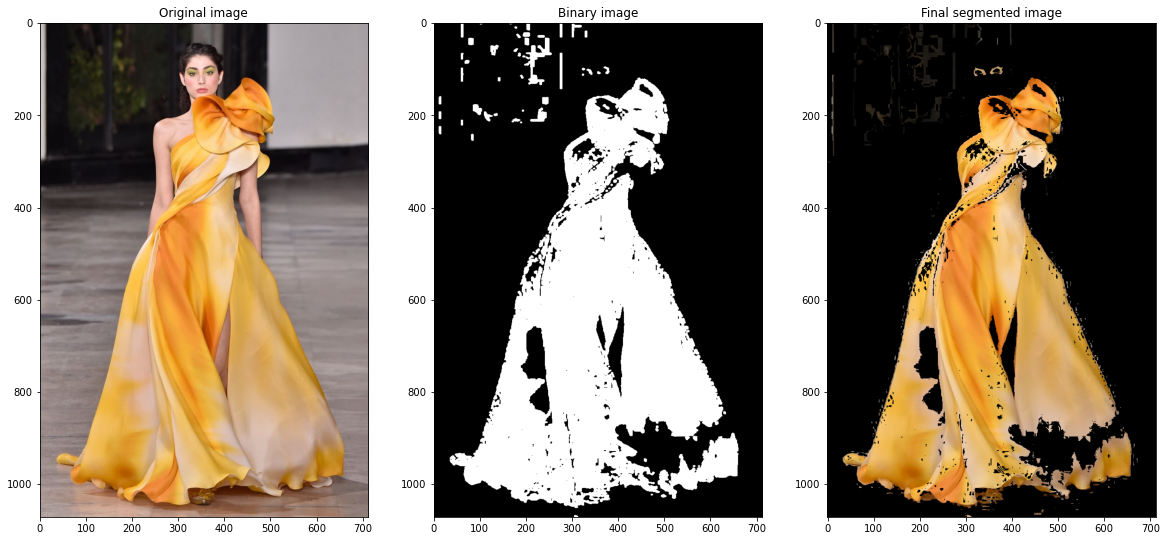

In [222]:
nonparametric_seg('Yellow.jpg',500,600,300,400, 180)

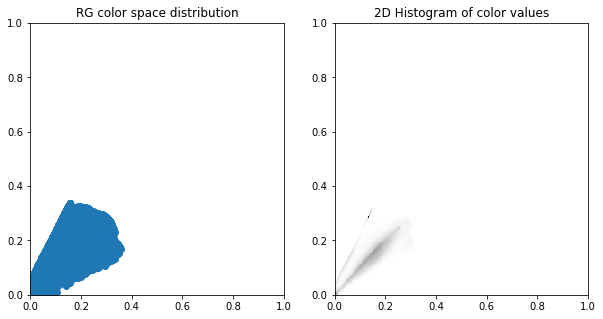

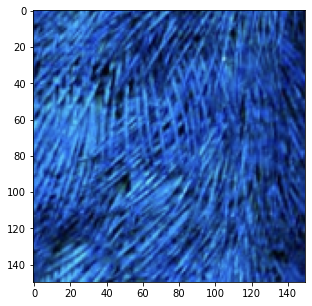

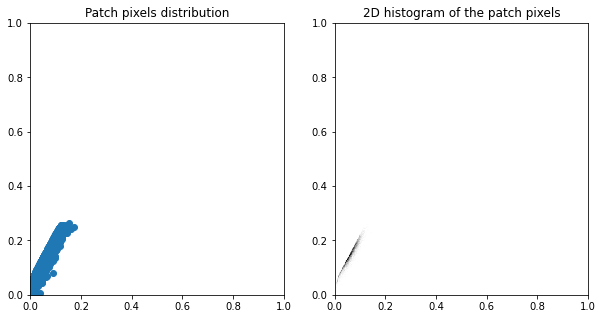

In [259]:
normalize_img('Peacock.png',1100,1250,1300,1450,100)

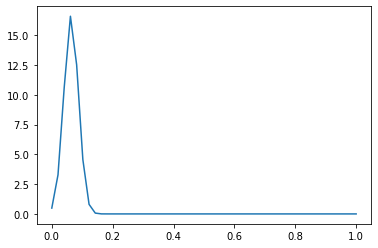

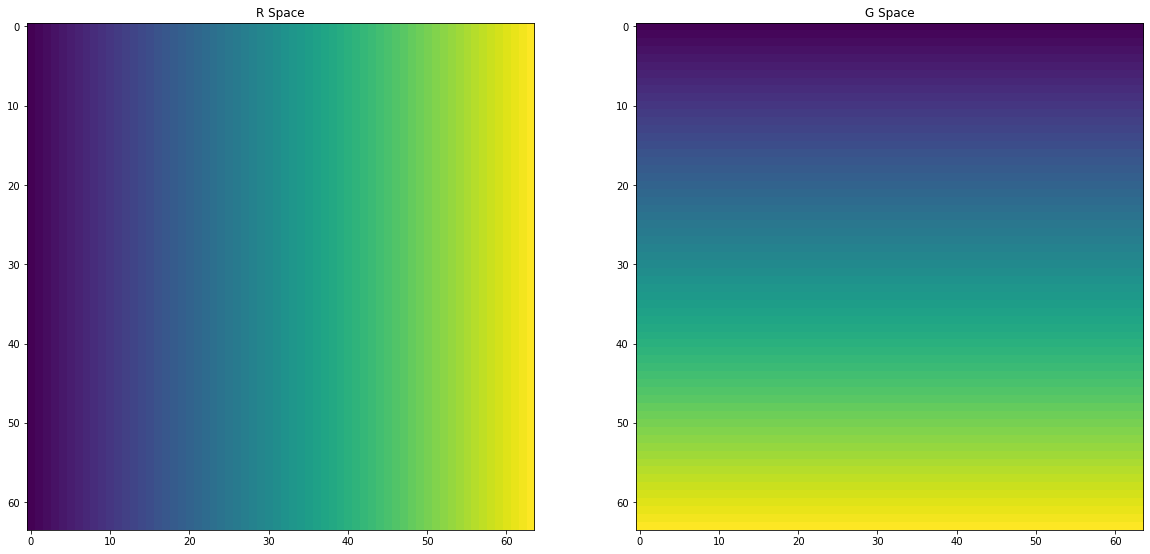

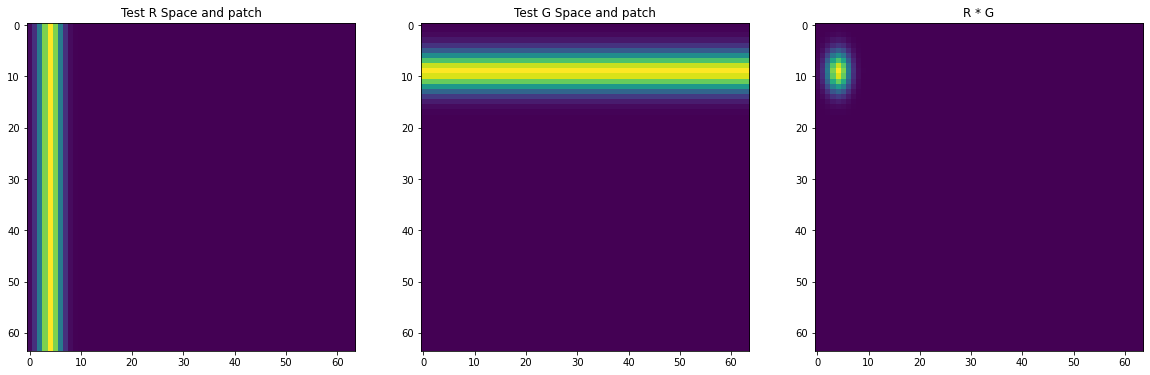

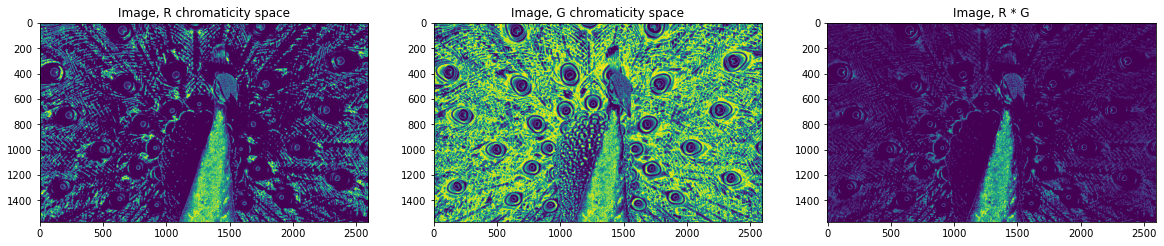

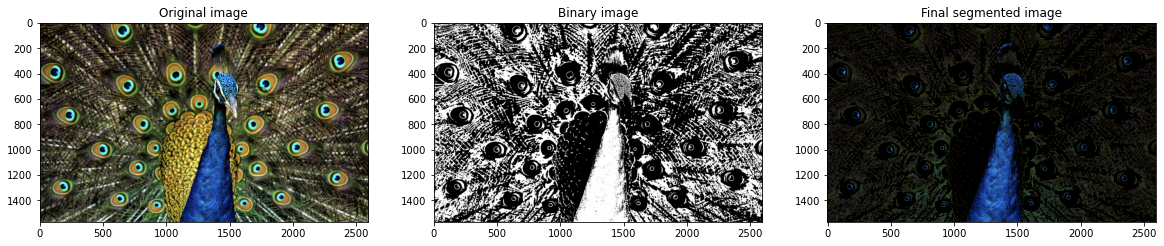

In [261]:
parametric_seg('Peacock.png',1100,1250,1300,1450)

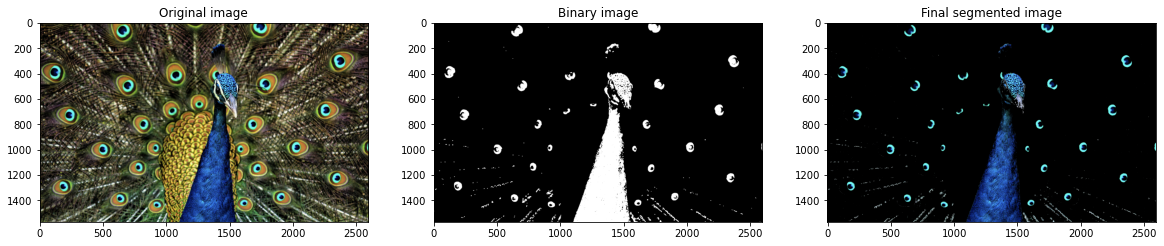

In [262]:
nonparametric_seg('Peacock.png',1100,1250,1300,1450,100)

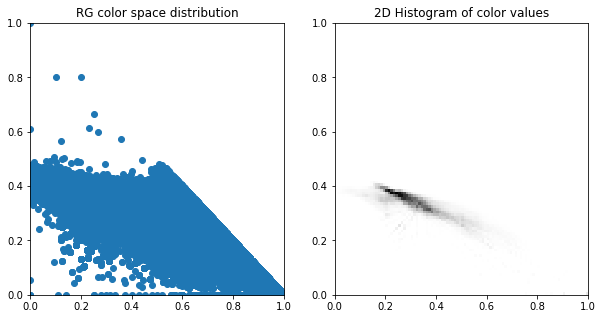

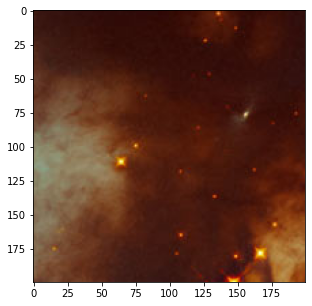

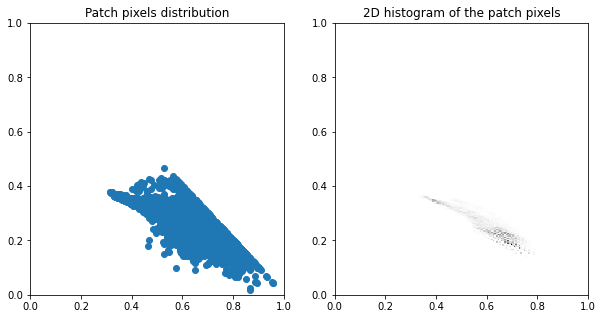

In [263]:
normalize_img('Nebula.jpg',700,900,500,700,100)

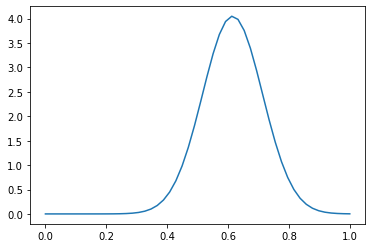

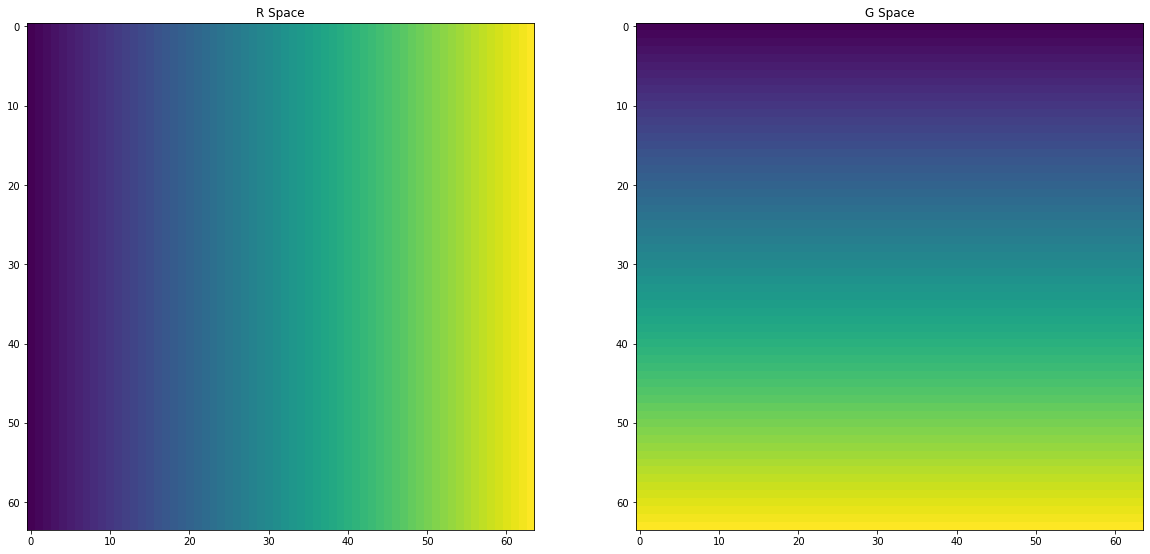

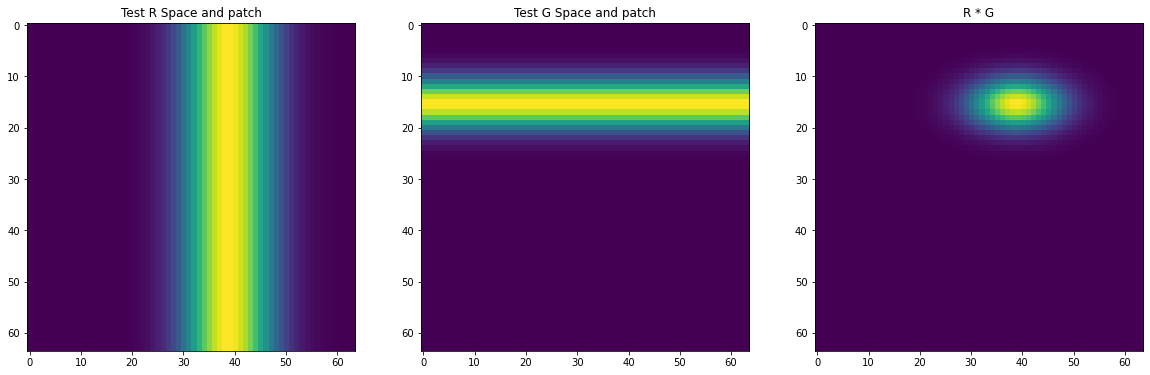

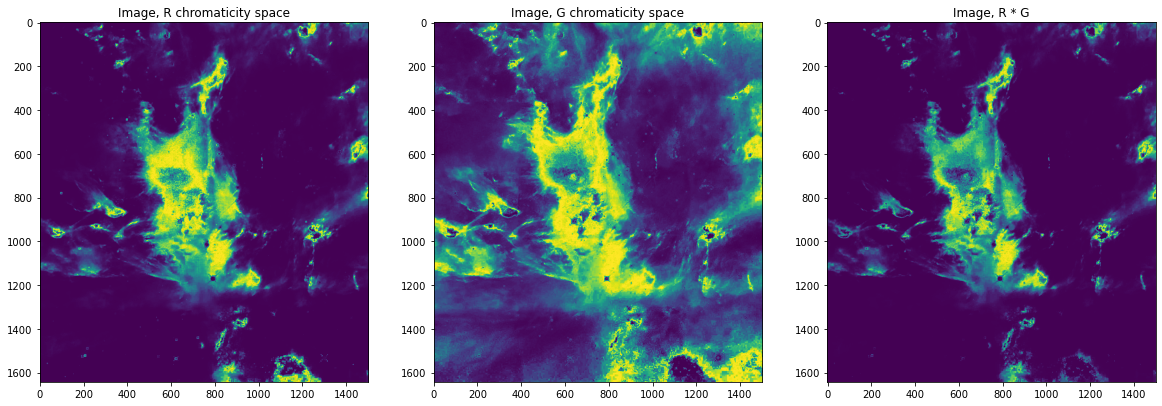

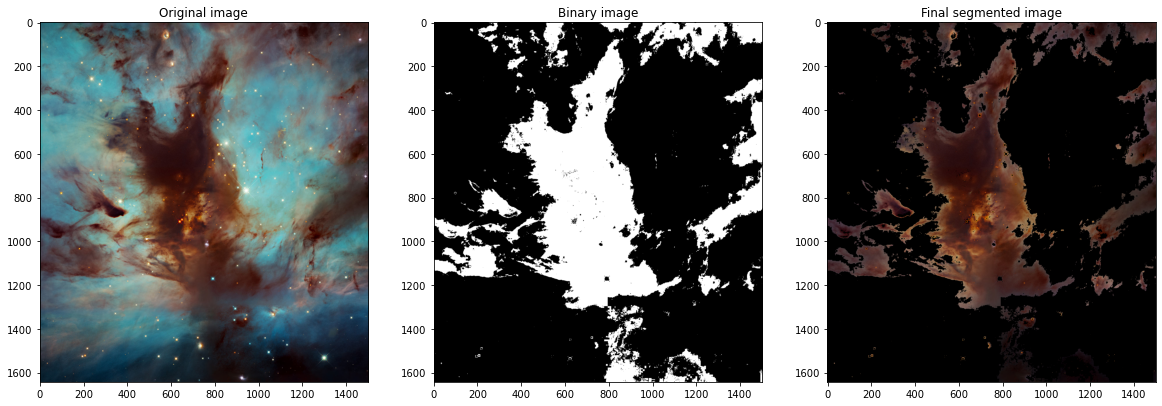

In [265]:
parametric_seg('Nebula.jpg',700,900,500,700)

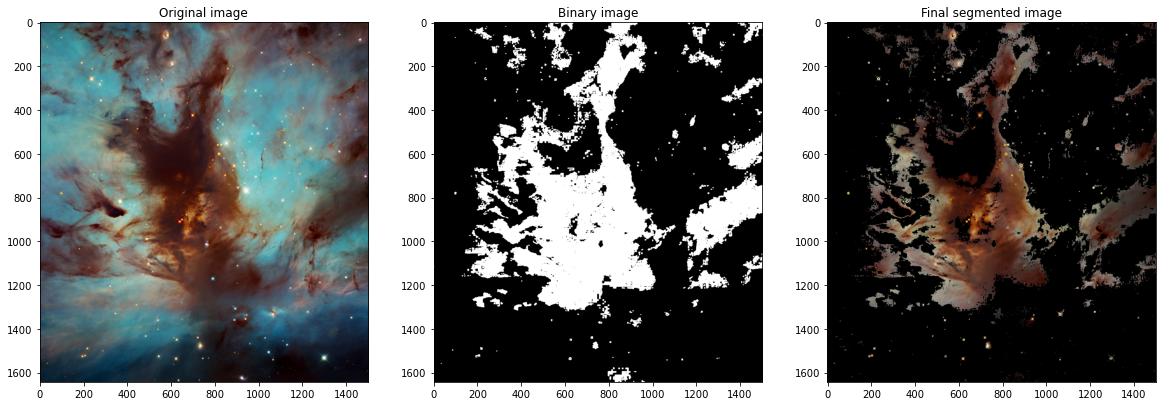

In [304]:
nonparametric_seg('Nebula.jpg',700,900,500,700,190)

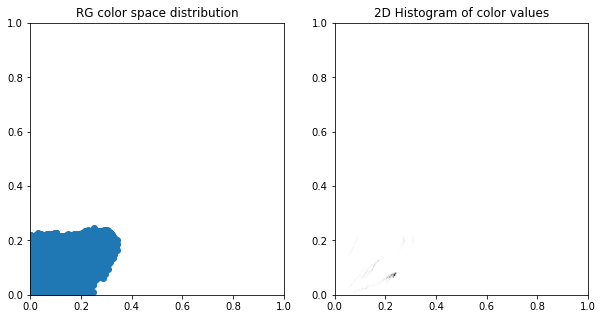

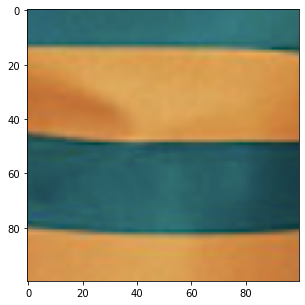

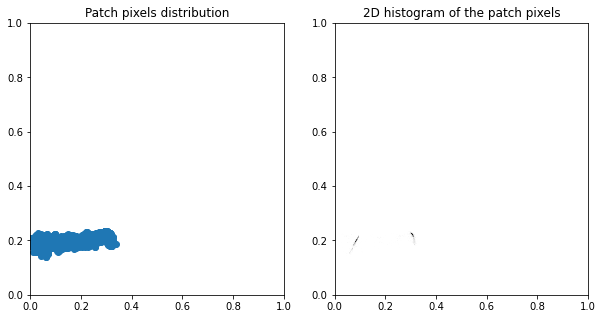

In [288]:
normalize_img('Stripes2.png',500,600,600,700, 100)

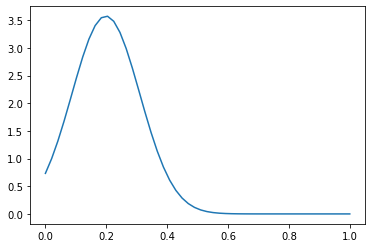

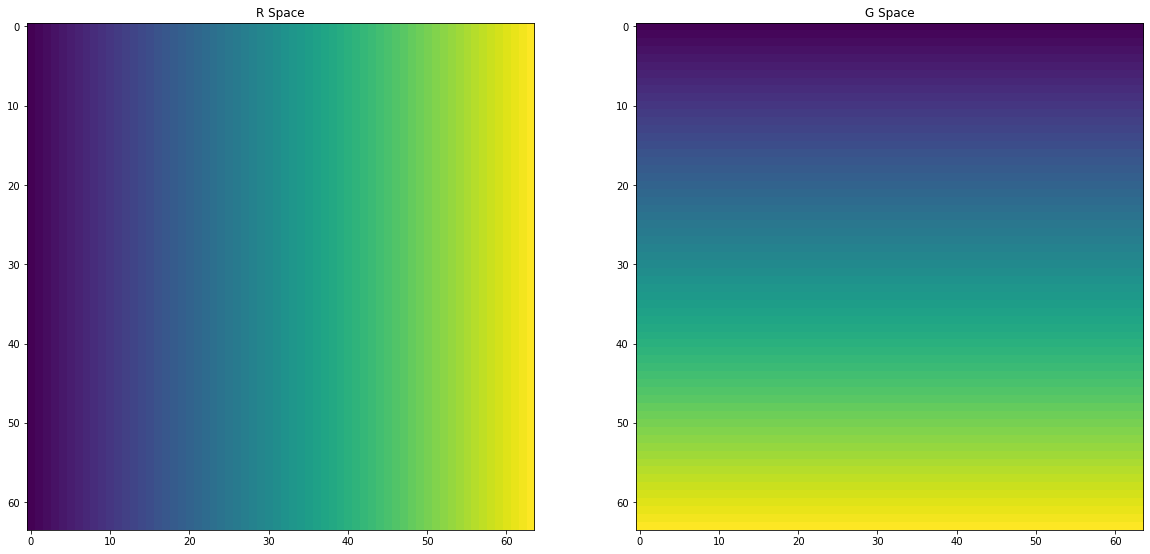

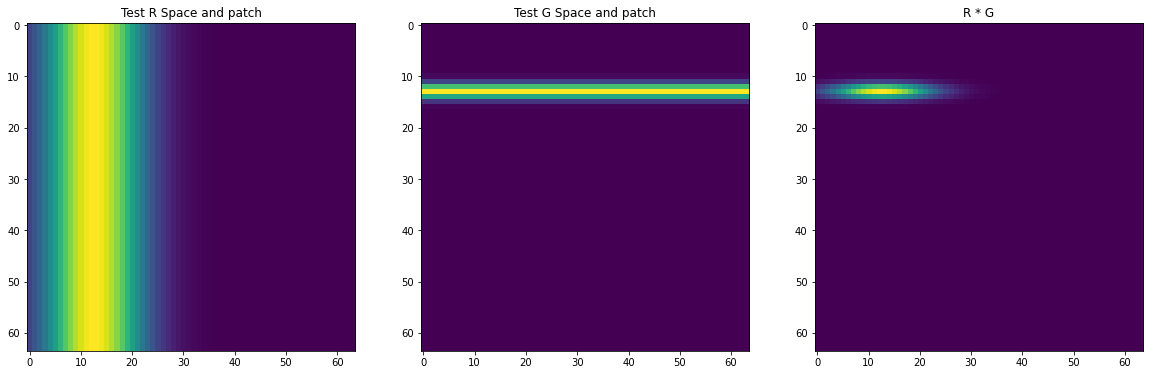

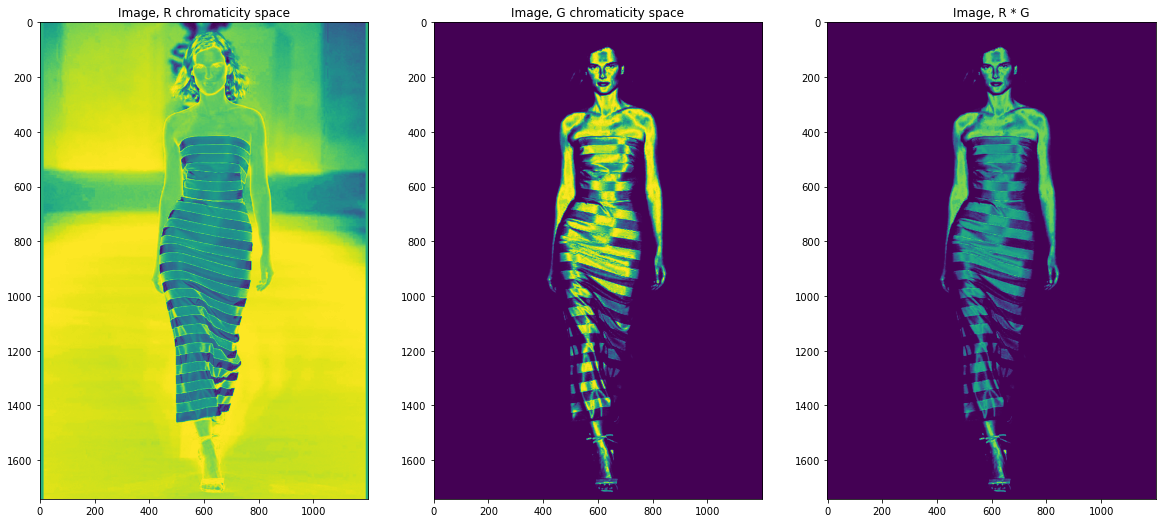

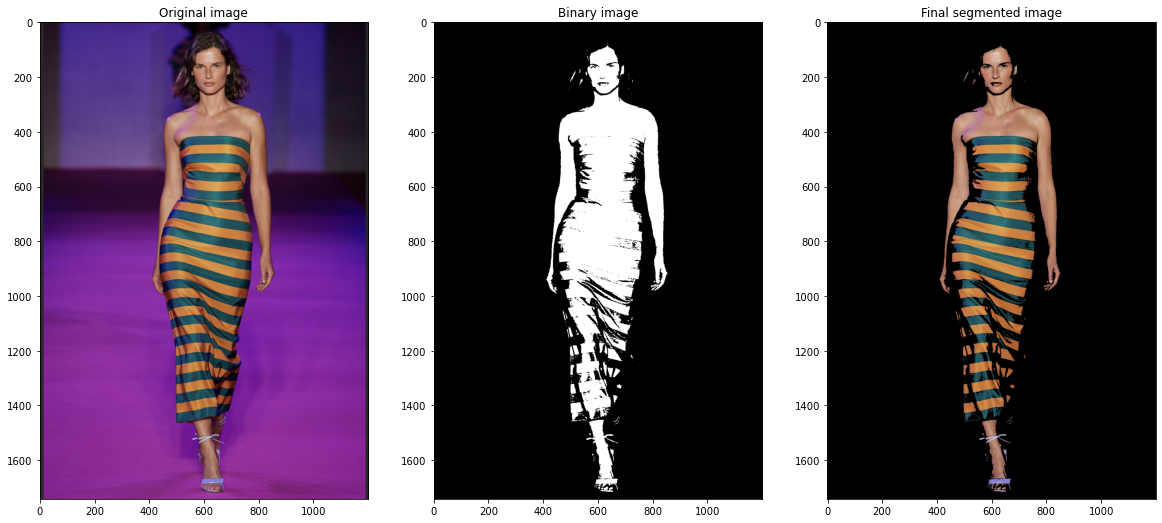

In [290]:
parametric_seg('Stripes2.png',500,600,600,700)

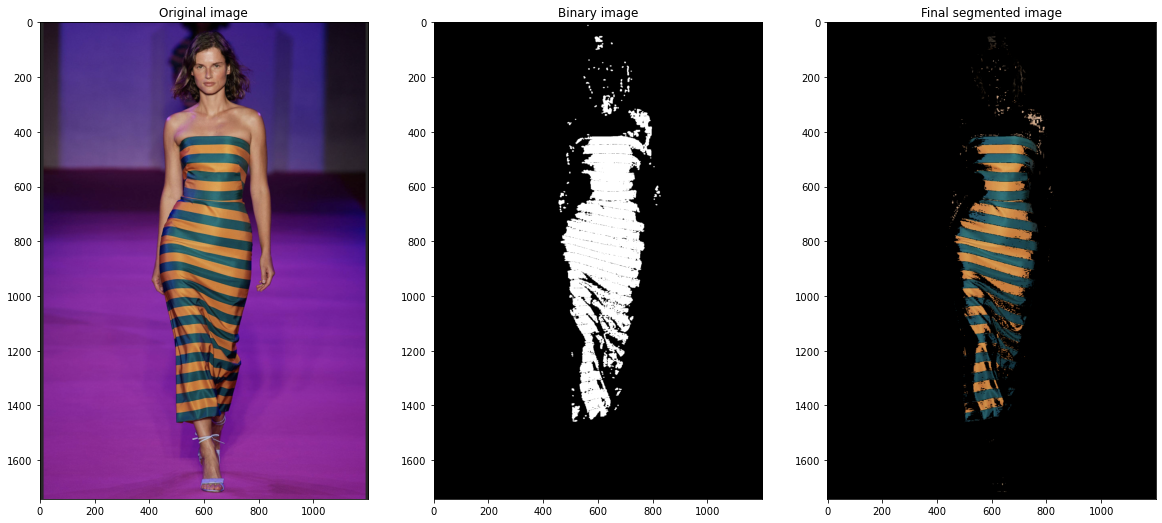

In [301]:
nonparametric_seg('Stripes2.png',500,600,600,700, 182)